In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
# Load data
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [3]:
# Convert to numpy
X = X.values
y = y.values.ravel().astype(int)

In [4]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [6]:
# Create dataset and split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
# Define neural network
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [8]:
# Instantiate model
num_classes, counts = np.unique(y, return_counts=True)
model = Classifier(input_dim=X.shape[1], num_classes=len(num_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
# Training loop
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    # print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
    # print(total_loss)

Epoch 10, Loss: 0.3807
Epoch 20, Loss: 0.3499
Epoch 30, Loss: 0.3361
Epoch 40, Loss: 0.3260
Epoch 50, Loss: 0.3202
Epoch 60, Loss: 0.3253
Epoch 70, Loss: 0.3171
Epoch 80, Loss: 0.3178
Epoch 90, Loss: 0.3159
Epoch 100, Loss: 0.3112


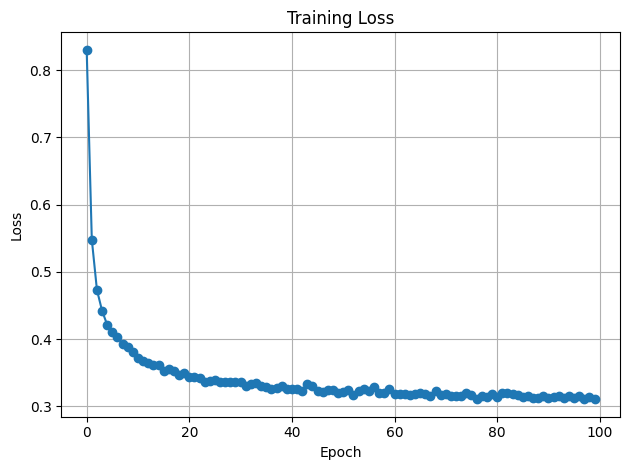

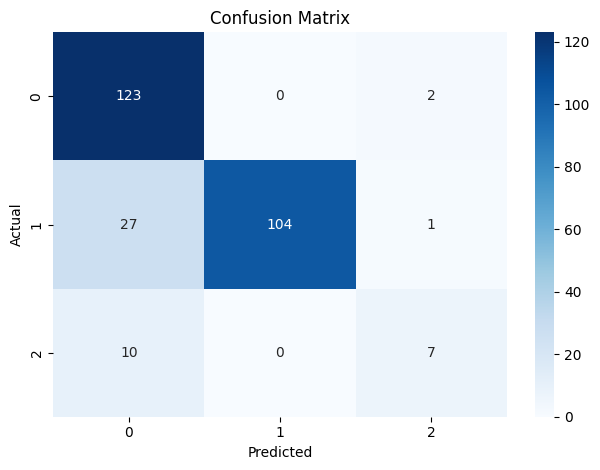

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       125
           1       1.00      0.79      0.88       132
           2       0.70      0.41      0.52        17

    accuracy                           0.85       274
   macro avg       0.82      0.73      0.75       274
weighted avg       0.88      0.85      0.85       274



In [10]:
# Plot Loss
plt.plot(losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_labels.extend(y_batch.tolist())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds))